# VarClump3D: Concept test on Orion

In [23]:
%matplotlib inline

import sys
import numba
from math import exp, sqrt
import numpy as np
import numpy.ma as ma
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, log, floor, ceil
from threading import Thread
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact, interactive, fixed

from mayavi import mlab

# VarClump functions
sys.path.append('../lib/')
from points_generation import *

# acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import load_fits, standarize

# extra metric module#
#import custom_metric as cm

## Helpers computing functions

In [3]:
def estimate_rms(data):
    """
    Computes RMS value of N-dimensional numpy array
    """

    if isinstance(data, ma.MaskedArray):
        ret = np.sum(data*data) / (np.size(data) - np.sum(data.mask)) 
    else: 
        ret = np.sum(data*data) / np.size(data)
    return np.sqrt(ret)


def estimate_entropy(data):
    """
    Computes Entropy of N-dimensional numpy array
    """

    # estimation of probabilities
    p = np.histogram(data.ravel(), bins=256, density=False)[0].astype(float)
    # little fix for freq=0 cases
    p = (p+1.)/(p.sum()+256.)
    # computation of entropy 
    return -np.sum(p * np.log2(p))


def estimate_variance(data):
    """
    Computes variance of N-dimensional numpy array
    """

    return np.std(data)**2


def compute_residual_stats(dfunc, c, sig, xc, yc, zc, dims, base_level=0.,
                           square_c=True, compact_supp=True, resolution=10):
    """
    Computes the residual stats between appproximation and real data
    """

    _xe = np.linspace(0., 1., dims[0]*resolution)[1:-1]
    _ye = np.linspace(0., 1., dims[1]*resolution)[1:-1]
    _ze = np.linspace(0., 1., dims[2]*resolution)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye); len_ze = len(_ze)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    
    #Computing distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    
    #Computing the Phi matrix
    if square_c: c = c**2
    if compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)
    u = np.dot(phi_m, c) + base_level
    u = u.reshape(len_xe, len_ye)

    residual = dfunc(_xe, _ye)-u
    return (estimate_variance(residual), 
            estimate_entropy(residual),
            estimate_rms(residual))

## Helpers visualization functions

In [73]:
"""
Helper function to visualize the quality of the solution
"""

def slices_plot(data, slc):
    plt.figure(figsize=(5,5))
    im = plt.imshow(data[slc], vmin=0, vmax=1.)
    plt.title('3D cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
def comparative_slices_plot(data1, data2, slc):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    im = plt.imshow(data1[slc], vmin=0, vmax=1.)
    plt.title('3D original cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.subplot(1,2,2)
    im = plt.imshow(data2[slc], vmin=0, vmax=1.)
    plt.title('3D approximated cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
@numba.jit('float64[:] (float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64, float64)', nopython=True)
def _compute_solution(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            if (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2 > supp**2 * sig[j]**2: continue
            ret[i] += c[j] * exp( -( (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2 ) / (2* (sig0**2 + sig[j]**2) ) )
    return ret

def compute_solution(c, sig, xc, yc, zc, dims, base_level=0., square_c=True, resolution=1):
    _xe = np.linspace(0., 1., resolution*dims[0]+2)[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1]+2)[1:-1]
    _ze = np.linspace(0., 1., resolution*dims[2]+2)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye); len_ze = len(_ze)
    Xe,Ye,Ze = np.meshgrid(_xe, _ye, _ze, indexing='ij', sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel(); ze = Ze.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    if square_c: c = c**2
    u = _compute_solution(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001) + base_level
    return u.reshape(len_xe, len_ye, len_ze)


@numba.jit('float64[:] (float64[:], float64[:], float64[:], float64[:], float64[:], \
           float64[:], float64[:], float64[:], float64, float64)', nopython=True, nogil=True)
def u_eval(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2
            if  dist2 > supp**2 * sig[j]**2: continue
            ret[i] += c[j] * exp( -dist2 / (2* (sig0**2 + sig[j]**2)) )
    return ret

In [68]:
# %timeit u_eval(c0, sig0, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001)

1 loop, best of 3: 1.57 s per loop


In [71]:
# @numba.jit('void (float64[:], float64[:], float64[:,:], float64[:,:], int64, int64, \
#            float64[:], float64, float64)', nopython=True, nogil=True)
# def u_eval(c, sig, epoints, cpoints, start, chunk_size, ret, supp=5., sig0=0.001):
#     m = len(epoints)
#     n = len(cpoints)
#     for i in range(start, min(start+chunk_size, m)):
#         for j in range(n):
#             dist2 = np.sum((epoints[i] - cpoints[i])**2)
#             if  dist2 > supp**2 * sig[j]**2: continue
#             ret[i] += c[j] * exp( -dist2 / (2* (sig0**2 + sig[j]**2)) )

# def thread_eval(c, sig, epoints, cpoints, n_thread=2):
#     chunk_size = len(epoints)/n_thread
    
#     ret = np.zeros(len(epoints))
    
#     start_index = [i*chunk_size for i in range(n_thread)]
    
#     threads = [Thread(target=u_eval, args=(c, sig, epoints, cpoints, start, chunk_size, ret, 5, 0.001)) for start in start_index]
    
#     for thread in threads:
#         thread.start()
#     for thread in threads:
#         thread.join()
    
#     return ret

In [72]:
# %timeit thread_eval(c0, sig0, collocation_points, center_points)

1 loop, best of 3: 14.5 s per loop


## Loading 3D data

In [26]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'

def load_data(fit_path):
    container = load_fits(fit_path)
    data = standarize(container.primary)[0]
    data = data.data

    # map to [0,1] range
    data -= data.min()
    data /= data.max()

    # generating the data function
    x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
    z = np.linspace(0., 1., data.shape[2]+2, endpoint=True)[1:-1]
    _dfunc = RegularGridInterpolator((x, y, z), data, method='linear', bounds_error=False, fill_value=0.)
    
#     def dfunc(points):
#         if points.ndim==1:
#             return _dfunc([[points[2],points[0],points[1]]])
#         elif points.ndim==2:
#             return _dfunc(points)
#             #return  _dfunc(np.roll(points, -1, axis=1))
    
    return x, y, z, data, _dfunc

x, y, z, data, dfunc = load_data(fit_path)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


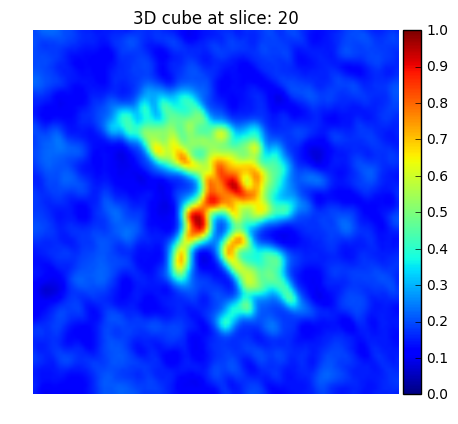

<function __main__.slices_plot>

In [27]:
interact(slices_plot, data=fixed(data), slc=(0, data.shape[0]-1))

In [28]:
#mlab.contour3d(data, contours=4, transparent=True)

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^3} L(x, y, z, u, u_x, u_y, u_z) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^3}(u(x,y,z)-f_0(x,y,z))^2 + \alpha \ \Psi_1(u(x,y,z)-f_0(x,y,z)) + \beta \ \Psi_2(\left|\nabla u(x,y,z)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y} -  \frac{d}{dz}\frac{\partial L}{\partial u_z}= 0$$

**2D case**:
$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

**3D case**:
$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y,z) = \sum_{i=1}^N c_i \ \phi(x, y, z;\ x_i, y_i, z_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$ (they will be the same)

In [29]:
"""
General Psi penalizing function (applicable in both cases)
"""
def psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('10*x**3 - 15*x**4 + 6*x**5')
    return ret

def d1psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('30*x**2 - 60*x**3 + 30*x**4')
    return lamb*ret

def d2psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('60*x - 180*x**2 + 120*x**3')
    return (lamb**2)*ret

## $\phi$-RBF function to use and its derivatives

In [30]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2)))')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2)] = 0.
    return retval

def phix(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * x')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * y')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * z')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phixx(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiyy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (y**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phizz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (z**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phiyx
def phixy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x*y)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phizx
def phixz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x*z)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phizy
def phiyz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (y*z)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

## Euler-Lagrange function class definition

In [31]:
"""
Euler-Lagrange class definition
"""
class ELFunc():
    def __init__(self, dfunc, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, d1psi1=None, d1psi2=None, d2psi2=None,
                 a=0., b=0., lamb1=1., lamb2=1., base_level=0, square_c=True, compact_supp=False):
        f0 = dfunc( np.vstack([xe,ye,ze]).T )
        fb = dfunc( np.vstack([xb,yb,zb]).T )
        #f0 = np.array([dfunc([xe[i],ye[i],ze[i]]) for i in range(len(xe))]).ravel()
        #fb = np.array([dfunc([xb[i],yb[i],zb[i]]) for i in range(len(xb))]).ravel()
        len_f0 = len(f0)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        Ne = len(xe)
        Nc = len(xc)
        Nb = len(xb)

#         """ 
#         Computing distance matrices
#         """
#         #distance matrices
#         Dx = np.empty((Ne,Nc))
#         Dy = np.empty((Ne,Nc))
#         Dz = np.empty((Ne,Nc))
#         for k in range(Ne):
#             Dx[k,:] = xe[k]-xc
#             Dy[k,:] = ye[k]-yc
#             Dz[k,:] = ze[k]-zc
#         #distance matrices for boundary points
#         Dxb = np.empty((Nb,Nc))
#         Dyb = np.empty((Nb,Nc))
#         Dzb = np.empty((Nb,Nc))
#         for k in range(Nb):
#             Dxb[k,:] = xb[k]-xc
#             Dyb[k,:] = yb[k]-yc
#             Dzb[k,:] = zb[k]-zc
            
#         """
#         Computing Phi matrices
#         """
#         if compact_supp:
#             phi_m = phi(Dx, Dy, Dz, sig0.reshape(1,-1))
#             if b!=0.:
#                 phix_m = phix(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phiy_m = phiy(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phiz_m = phiz(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phixx_m = phixx(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phiyy_m = phiyy(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phizz_m = phizz(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phixy_m = phixy(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phixz_m = phixz(Dx, Dy, Dz, sig0.reshape(1,-1))
#                 phiyz_m = phiyz(Dx, Dy, Dz, sig0.reshape(1,-1))
#         else:
#             phi_m = phi(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#             if b!=0.:
#                 phix_m = phix(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phiy_m = phiy(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phiz_m = phiz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phixx_m = phixx(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phiyy_m = phiyy(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phizz_m = phizz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phixy_m = phixy(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phixz_m = phixz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
#                 phiyz_m = phiyz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
        
        """
        Storing important atributes
        """
        self.dfunc = dfunc
        self.f0 = f0
        self.fb = fb
        self.xe = xe; self.ye = ye; self.ze = ze
        self.xc = xc; self.yc = yc; self.zc = zc
        self.xb = xb; self.yb = yb; self.zb = zb
#         self.Dx = Dx; self.Dxb = Dxb
#         self.Dy = Dy; self.Dyb = Dyb
#         self.Dz = Dz; self.Dzb = Dzb
#         self.phi_m = phi_m
#         if b!=0.:
#             self.phix_m = phix_m
#             self.phiy_m = phiy_m
#             self.phiz_m = phiz_m
#             self.phixx_m = phixx_m
#             self.phiyy_m = phiyy_m
#             self.phizz_m = phizz_m
#             self.phixy_m = phixy_m
#             self.phixz_m = phixz_m
#             self.phiyz_m = phiyz_m
        self.c = c0
        self.sig = sig0
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.base_level = base_level
        self.square_c = square_c
        self.compact_supp = compact_supp

    def set_centers(self, xc, yc, zc):
#         xe = self.xe; ye = self.ye; ze = self.ze
#         xb = self.xb; yb = self.yb; zb = self.zb
#         Ne = len(xe)
#         Nc = len(xc)
#         Nb = len(xb)

#         # re-computing distance matrices
#         Dx = np.empty((Ne,Nc))
#         Dy = np.empty((Ne,Nc))
#         Dz = np.empty((Ne,Nc))
#         for k in range(Ne):
#             Dx[k,:] = xe[k]-xc
#             Dy[k,:] = ye[k]-yc
#             Dz[k,:] = ze[k]-zc

#         # re-computing distance matrices for boundary points
#         Dxb = np.empty((Nb,Nc))
#         Dyb = np.empty((Nb,Nc))
#         Dzb = np.empty((Nb,Nc))
#         for k in range(Nb):
#             Dxb[k,:] = xb[k]-xc
#             Dyb[k,:] = yb[k]-yc
#             Dzb[k,:] = zb[k]-zc
        
        self.xc = xc; self.yc = yc; self.zc = zc
#         self.Dx = Dx; self.Dy = Dy; self.Dz = Dz
#         self.Dxb = Dxb; self.Dyb = Dyb; self.Dzb = Dzb
        
    def set_c(self, c):
        self.c = c

    def set_sig(self, sig):
        self.sig = sig
#         """
#         Re-computing Phi matrices
#         """
#         if self.compact_supp:
#             phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#             if self.b!=0.:
#                 phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#         else:
#             phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#             if self.b!=0.:
#                 phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
    
    def F(self, X):
        N = len(X)/5
        xc = X[0:N]
        yc = X[N:2*N]
        zc = X[2*N:3*N]
        
        xe = self.xe; ye = self.ye; ze = self.ze
        
        if self.square_c: c = X[3*N:4*N]**2
        else: c = X[3*N:4*N]
        sig = X[4*N:5*N]
        
#         """
#         Computing Phi matrices
#         """
#         if self.compact_supp:
#             phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#             if self.b!=0.:
#                 phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#                 phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
#         else:
#             phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#             if self.b!=0.:
#                 phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
#                 phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
        
        """
        Computing u, ux, uy, ...
        """
        #u = np.dot(phi_m, c) + self.base_level
        u = u_eval(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001) + self.base_level
        el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
#         if self.b!=0.:
#             ux = np.dot(phix_m, c)
#             uy = np.dot(phiy_m, c)
#             uz = np.dot(phiz_m, c)
#             uxx = np.dot(phixx_m, c)
#             uyy = np.dot(phiyy_m, c)
#             uzz = np.dot(phizz_m, c)
#             uxy = np.dot(phixy_m, c)
#             uxz = np.dot(phixz_m, c)
#             uyz = np.dot(phiyz_m, c)
        
#         """
#         Computing the EL equation
#         """
#         if self.b!=0.:
#             el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1) - \
#                 2*self.b*(2*self.d2psi2(ux**2 + uy**2 + uz**2, self.lamb2) * (ux**2 * uxx + uy**2 * uyy + uz**2 * uzz + \
#                 2*(ux*uy*uxy + ux*uz*uxz + uy*uz*uyz)) + \
#                 self.d1psi2(ux**2 + uy**2 + uz**2, self.lamb2)*(uxx + uyy + uzz))
#         else: 
#             el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        
#         """
#         Boundary conditions (threshold must be added)
#         """
#         bc = np.dot(phi(self.Dxb, self.Dyb, self.Dzb, sig.reshape(1,-1)), c) + self.base_level - self.fb
#         return np.concatenate([el,bc])
        return el

$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

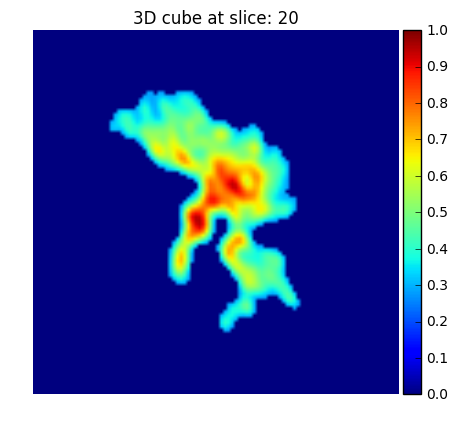

<function __main__.slices_plot>

In [32]:
base_level = 1.5*estimate_rms(data)
_data = np.copy(data)
mask = data > base_level
_data[~mask] = 0. 
interact(slices_plot, data=fixed(_data), slc=(0, _data.shape[0]-1))

In [55]:
"""
Boundary points
"""
#number of boundary points by side
Nb = 0
Nc = 4000
Ne = 5*Nc-4*Nb

xb = []
yb = []
zb = []

for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(val)
    yb.append(0.)
for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(1.)
    yb.append(val)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(val)
    yb.append(1.)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(0.)
    yb.append(val)
xb = np.asarray(xb)
yb = np.asarray(yb)
zb = np.asarray(zb)
boundary_points = np.vstack([xb,yb,zb]).T

In [56]:
def _inv_gaussian_kernel(kernlen=3, sig=0.1):
    """
    Returns a 2D Gaussian kernel array.
    """
    interval = (2*sig+1.)/(kernlen)
    x = np.linspace(-sig-interval/2., sig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel.max()-kernel

def random_centers_generation(data, n_centers, base_level=None, power=5.):
    # fixed seed
    np.random.seed(0)
    
    data = np.copy(data)
    
    # unusable pixels mask
    if base_level is not None:
        mask = data <= base_level
        if np.sum(~mask) < n_centers:
            print('The number of usable pixels is less than n_centers')
            return None
        
    # applying power and re-normalizing
    data **= power
    data /= data.max()

    # data dimensions
    l,m,n = data.shape
    
    # center points positions
    x = np.linspace(0., 1., l+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., m+2, endpoint=True)[1:-1]
    z = np.linspace(0., 1., n+2, endpoint=True)[1:-1]
    X,Y,Z = np.meshgrid(x,y,z, indexing='ij')
    points_positions = np.vstack( [ X.ravel(), Y.ravel(), Z.ravel() ]).T
    
    # array with indexes of such centers
    points_indexes = np.arange(0, points_positions.shape[0], dtype=int)
    
    # array with probabilities of selection for each center
    if isinstance(mask, np.ndarray):
        data[mask] = 0.
        prob = data/data.sum()
    else:
        prob = data/data.sum()
    
    # convolution kernel
    #K = np.array([[0.5, 0.5, 0.5], [0.5, 0., 0.5], [0.5, 0.5, 0.5]])
    #K = _inv_gaussian_kernel(kernlen=3, sig=3.)
    
    selected = []
    while len(selected)!=n_centers:
        sel = np.random.choice(points_indexes, size=1 , p=prob.ravel(), replace=False)[0]
        # border pixels can't be selected
        index0 = sel / (m*n)
        index1 = (sel/ n) % m 
        index2 = sel % n
        if index0==0 or index0==l-1 or index1==0 or index1==m-1 or index2==0 or index2==n-1: continue
        selected.append(sel)
        # update the pixel probabilities array
        #prob[index0-1:index0+2, index1-1:index1+2] *= K
        prob[index0-1:index0+2, index1-1:index1+2, index2-1:index2+2] *= 0.5
        prob[index0, index1, index2] *= 0.
        prob /= prob.sum()
        
    return points_positions[selected]

In [57]:
base_level = 1.5*estimate_rms(data)

center_points = random_centers_generation(data, Nc, base_level=base_level, power=5.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3, get_size=100)

In [58]:
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]

### Visualization of points

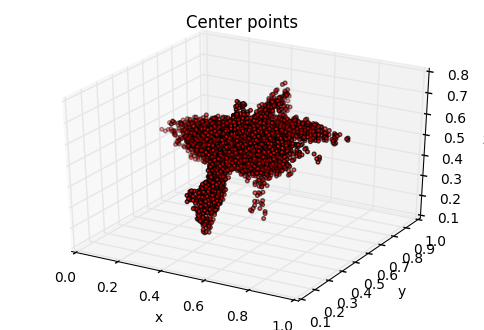

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

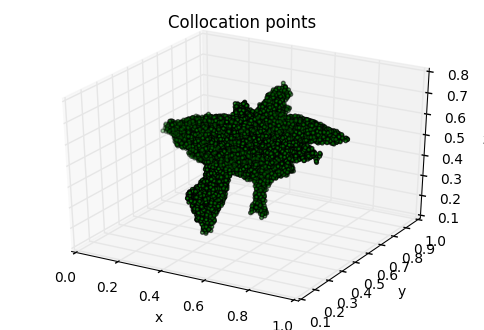

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()

## Initial Conditions

In [63]:
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
dist_matrix = np.sqrt(Dx**2+Dy**2)

In [64]:
def estimate_initial_guess(center_points, dist_matrix, dfunc, R=0.05, minsig=0.001, method='min_dist'):
    m = center_points.shape[0]
    c_arr = np.empty(m, dtype=float)
    sig_arr = np.empty(m, dtype=float)
    
    if method=='mean_dist':
        f = 1./sqrt(log(2.))
        mean_dist = np.zeros(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)   
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                #dont take into account points outside R radius
                if d>R: continue
                num_neigh[i] += 1
                mean_dist[i] += d
            """
            Key Idea: The mean distance to neighbors acurrs when the
            gaussian function has decayed to the half
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = minsig
            else:
                mean_dist[i] /= num_neigh[i]
                c_arr[i] = dfunc(*center_points[i])[0]/num_neigh[i]
                #c_arr[i] = dfunc(*center_points[i])[0]*mean_dist[i]**2
                sig_arr[i] = f*mean_dist[i]
                
    elif method=='min_dist':
        min_dist = np.inf*np.ones(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)
        #first we find the distance to the nearest neighbor
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d<min_dist[i]: min_dist[i] = d
        #second, we find the number of neighbors on the neighborhood
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d > 3*min_dist[i]: continue
                num_neigh[i] += 1
            """
            some explanation here
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = minsig
            else:
                c_arr[i] = dfunc(*center_points[i])[0]/(num_neigh[i]+1)
                sig_arr[i] = min_dist[i] 
    return (c_arr,sig_arr)

In [65]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
#c0, sig0 = estimate_initial_guess(center_points, dist_matrix, f, minsig=minsig, method='min_dist')
c0 = 0.01 * np.ones(Nc)
sig0 = 0.05 * np.ones(Nc)

In [66]:
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)

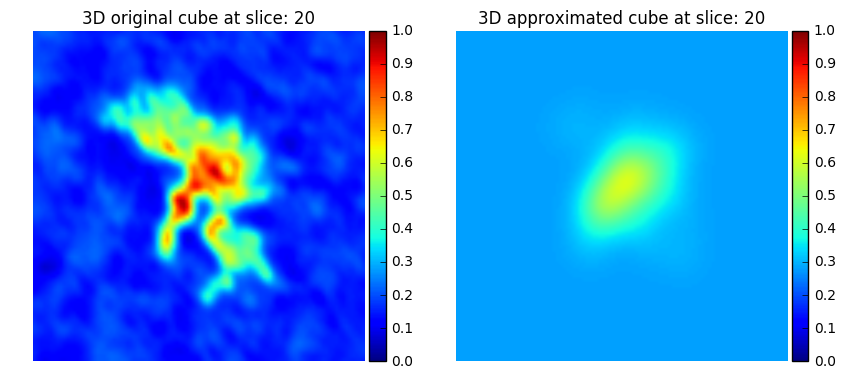

<function __main__.comparative_slices_plot>

In [43]:
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

## Visualizing the initial solution

In [46]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
#plot_sol(c0, sig0, xc, yc, base_level=0., compact_supp=False)
#params_plot(c0, sig0, xc, yc, square_c=True)
#params_distribution_plot(c0, sig0, square_c=True)

# Experiments

In [47]:
def el_solver(elf, method='iterative', n_iter=5, verbose=True, base_level=0., 
              square_c=True, compact_supp=False, step_iter=2000, max_iter=100000):
    # number of centers/parameters
    Nc = len(elf.xc)

    if method=='exact':
        residual_variance = []
        residual_entropy = []
        residual_rms = []
        iter_list = range(step_iter, max_iter+1, step_iter)
        
        for it in iter_list:
            print('\n'+'#'*90)
            print('Results after {0} iterations'.format(it))
            print('#'*90)
            # lm optimization
            sol = sp.optimize.root(elf.F, np.concatenate([elf.xc, elf.yc, elf.zc, elf.c, elf.sig]),
                                   method='lm', options={'maxiter':step_iter})
            sol_length = len(sol.x)/5
            opt_xc = sol.x[0:sol_length]
            opt_yc = sol.x[sol_length:2*sol_length]
            opt_zc = sol.x[2*sol_length:3*sol_length]
            opt_c = sol.x[3*sol_length:4*sol_length]
            opt_sig = sol.x[4*sol_length:5*sol_length]
            
            # variation of centers, c and sig
            delta_xc = np.linalg.norm(opt_xc-elf.xc)
            delta_yc = np.linalg.norm(opt_yc-elf.yc)
            delta_zc = np.linalg.norm(opt_zc-elf.zc)
            delta_c = np.linalg.norm(opt_c-elf.c)
            delta_sig = np.linalg.norm(opt_sig-elf.sig)
            
            # searching for noisy gaussians (and removing them)
            mask = np.abs(opt_sig)<1.
            if np.any(~mask):
                print('{0} noisy gaussians detected and removed! \n'.format(np.sum(~mask)))
                opt_xc = opt_xc[mask]
                opt_yc = opt_yc[mask]
                opt_zc = opt_zc[mask]
                opt_c = opt_c[mask]
                opt_sig = opt_sig[mask]
                
            
            # update of best parameters
            elf.set_centers(opt_xc, opt_yc, opt_zc)
            elf.set_c(opt_c)
            elf.set_sig(opt_sig)
            
            # residual stats
            #var,entr,rms = compute_residual_stats(elf.dfunc, opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
            #         square_c=square_c, compact_supp=compact_supp)
            
            # appending residual variance, entropy and rms
            #residual_variance.append(var)
            #residual_entropy.append(entr)
            #residual_rms.append(rms)
            
            print('Variation on xc = {0}'.format(delta_xc))
            print('Variation on yc = {0}'.format(delta_yc))
            print('Variation on zc = {0}'.format(delta_zc))
            print('Variation on c = {0}'.format(delta_c))
            print('variation on sig = {0}'.format(delta_sig))
            print('\nsuccess: {0}'.format(sol['success']))
            print('\nstatus: {0}'.format(sol['status']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nnfev: {0}'.format(sol['nfev']))
            if sol['success']: break
        
        print('\n \n' + '#'*90)    
        print('FINAL RESULTS:')
        print('#'*90)
        
        # plots generation
        # solution_plot(elf.dfunc, opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, square_c=square_c, compact_supp=compact_supp)
        # params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        # params_distribution_plot(elf.c, elf.sig, square_c=square_c)
        # residual_plot(residual_variance, residual_entropy, residual_rms, iter_list[0:len(residual_rms)])
    

        print('\n \n' + '#'*90)    
        print('FINAL RESULTS:')
        print('#'*90)
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_rms, 'go-')
        plt.title('Residual RMS')        
        plt.subplot(1,3,2)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_variance, 'bo-')
        plt.title('Residual variance')
        plt.subplot(1,3,3)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_entropy, 'ro-')
        plt.title('Residual entropy')
        plt.show()

## Experiments 1
The following instances test with different settings combinations for: square_c and support

In [48]:
"""
ELFunc instantiations
"""

base_level = 1.5*estimate_rms(data)

elf01 = ELFunc(dfunc, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True)

### C-squared and `base_level=RMS`


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on xc = 0.375506410989
Variation on yc = 0.470359789665
Variation on zc = 0.41029629663
Variation on c = 0.499313473516
variation on sig = 0.192332648985

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on xc = 0.142758964221
Variation on yc = 0.998958522607
Variation on zc = 0.685788030923
Variation on c = 7.0796222078
variation on sig = 0.180521316706

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

######################################

ValueError: x and y must have same first dimension

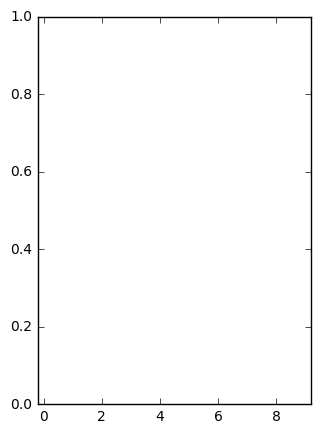

In [49]:
el_solver(elf01, method='exact', base_level=base_level, square_c=True, step_iter=2000, max_iter=10000)

In [50]:
u_sol = compute_solution(elf01.c, elf01.sig, elf01.xc, elf01.yc, elf01.zc, dims=data.shape)

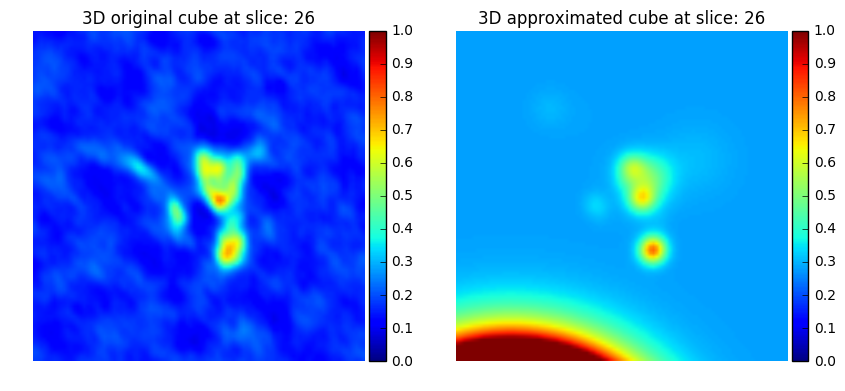

In [51]:
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

In [76]:
mlab.contour3d(data)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



ImportError: Could not import backend for traits
_______________________________________________________________________________
Make sure that you have either the TraitsBackendWx or the TraitsBackendQt
projects installed. If you installed Mayavi with easy_install, try
easy_install <pkg_name>. easy_install Mayavi[app] will also work.

If you performed a source checkout, be sure to run 'python setup.py install'
in Traits, TraitsGUI, and the Traits backend of your choice.

Also make sure that either wxPython or PyQT is installed.
wxPython: http://www.wxpython.org/
PyQT: http://www.riverbankcomputing.co.uk/software/pyqt/intro
